In [3]:
!pip install torch==1.10

In [45]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as trf
import torchvision.models as models
import torchvision

import numpy as np
import pandas as pd

import cv2
import json
from io import StringIO

import random
import re

import torchvision.transforms as trf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image as PImage

from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_
from tqdm.notebook import tqdm as tqdm_step

from xml.dom import minidom
import random
import copy
import time

from os import listdir

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics

In [46]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
#assert torch.__version__.startswith("1.10")   # please ma    "path":"dataset.json", nually install torch 1.9 if Colab changes its default version

1.10.0+cu102 True


In [47]:
params = {
    "path":["./DBeaver_dataset.json", "./MonitorOff_dataset.json", "./PyCharm_dataset.json", "./SSMS_dataset.json", "./VisualStudio_dataset.json", "./Windows_enter_dataset.json"],
    "path_img":"./Dataset/",
    "lr_recognition": 0.0000001,
    "lr": 0.000001,
    "batch_size": 1,
    "num_workers": 4,
    "epochs": 20,
    "size": 512,
    "size_recognition": 128,
    "device": "cpu", #torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "path_model_boxs":"./models/box_vga_dict_2_2.mdl",
    "path_model_recognasion":"./models/recognation2_vga.mdl",
    "embedding_dims": 128,
    'batch_size': 1
}

In [48]:
class CNN(nn.Module):
    def __init__(self, **kwargs):
        super(CNN, self).__init__()
        self.convlayer_1 = nn.Sequential(
            nn.Conv2d(in_channels=kwargs["input_shape"], out_channels=16, kernel_size=(5, 5)),
            nn.MaxPool2d(2, stride=2),
        )
        
        self.convlayer_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5)),
            nn.MaxPool2d(2, stride=2),
        )
        
        self.convlayer_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5)),
            nn.MaxPool2d(2, stride=2),
        )
        
        self.convlayer_4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=92, kernel_size=(5, 5)),
            nn.MaxPool2d(2, stride=2),
        )
        
        self.convlayer_5 = nn.Sequential(
            nn.Conv2d(in_channels=92, out_channels=128, kernel_size=(5, 5)),
            nn.MaxPool2d(2, stride=2),
        )
        
        self.convlayer_6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=160, kernel_size=(5, 5)),
            nn.MaxPool2d(2, stride=2),
        )
        
        
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2560, out_features=2048, bias=False),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=2048, out_features=1024, bias=False),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512, bias=False),
        )
        #self.flatten = nn.Sequential(
        #    nn.Linear(in_features=512, out_features=4, bias=True),
        #)
        
        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=256, bias=False),
            nn.Linear(in_features=256, out_features=128, bias=False),
            nn.Linear(in_features=128, out_features=64, bias=False),
            nn.Linear(in_features=64, out_features=4, bias=True),
        )
        
        
    def forward(self, x):
        x = nn.functional.relu(self.convlayer_1(x))
        x = nn.functional.relu(self.convlayer_2(x))
        x = nn.functional.relu(self.convlayer_3(x))
        x = nn.functional.relu(self.convlayer_4(x))
        x = nn.functional.relu(self.convlayer_5(x))    
        x = nn.functional.relu(self.convlayer_6(x))     
        
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        x = nn.functional.sigmoid(self.flatten(x))
        
        return x

In [49]:
device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_boxs = CNN(input_shape=3).to(device)
criterion = nn.MSELoss()

In [50]:
try:
    #model_boxs = torch.load(params['path_model_boxs'])
    model_boxs.load_state_dict(torch.load('./models/box_vga_dict_2_2.mdl'))
except Exception as ex:
    print(ex)

In [51]:
data = []
for path in params['path']:
    with open(path, 'r') as file:
        temp = file.read().replace('\n', '')
        temp = json.load(StringIO(temp))
        data.append(temp)

In [52]:
train_torch_transform = trf.Compose([
    trf.ToPILImage(),
    trf.Resize((int(params['size']), int(params['size']))),
    #trf.Resize((int(params['size'] * 1.3), int(params['size'] * 1.3))),
    #trf.RandomCrop((params['size'], params['size'])),
    #trf.RandomRotation(10.0),
    trf.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.05, hue=0.05), 
    trf.ToTensor(),
])

test_torch_transform = trf.Compose([
    trf.ToPILImage(),
    trf.Resize((params['size'], params['size'])),
    trf.ToTensor(),
])

In [53]:
arr = []
targets = []
images_link = []

In [54]:
global_idx = 0
for data_sample in data:
    img_list = data_sample['project']['vid_list']

    for idx in img_list:
        #try:
            image = mpimg.imread(f"{params['path_img']}{'_'.join(data_sample['file'][idx]['fname'].split('_')[:-1])}/{data_sample['file'][idx]['fname']}")
            #print(data['metadata'][[e for e in data['metadata'] if re.match(f'^{idx}_', e)][0]]['av']['1'])
        
            target_idx = [e for e in data_sample['metadata'] if re.match(f'^{idx}_', e)]
            if len(target_idx) > 0:
                tmp = data_sample['metadata'][[e for e in data_sample['metadata'] if re.match(f'^{idx}_', e)][0]]['av']
                if '1' in tmp.keys():
                    images_link.append(f"{params['path_img']}{'_'.join(data_sample['file'][idx]['fname'].split('_')[:-1])}/{data_sample['file'][idx]['fname']}")
                    target = data_sample['metadata'][[e for e in data_sample['metadata'] if re.match(f'^{idx}_', e)][0]]['av']['1']

                    sp = np.shape(image)

                    img = test_torch_transform(np.uint8(image*255))
                    box1 = model_boxs(torch.tensor(np.array([img.detach().numpy()]))).detach().numpy()[0]
                    image = image[int(box1[1] * sp[0]):int(box1[3] * sp[0])+1,int(box1[0] * sp[1]):int(box1[2] * sp[1])+1, :]
                    #image = test_torch_transform(image)
                    #image = np.moveaxis(image, 0, -1)lr_recognition
                    #print(np.shape(image))
                    #print(test_torch_transform(np.uint8(image*255)))
                    matrix = torch.flatten(torch.tensor(np.int32(img*255)), start_dim=1).numpy()
                    #matrix[0] *= 1000000
                    #matrix[1] *= 1000
                    matrix = np.sum(matrix, axis=0)
                    #matrix = np.sum(matrix, axis=0) / 3
                    targets.append(target)
                    np.save(f'{params["path_img"]}data_{global_idx}.npy', matrix)
                    arr.append(global_idx) 
                    global_idx += 1
                    #arr.append(matrix)
        #except Exception as ex:
        #    print(ex)
arr = np.array(arr)

/home/viktor/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [55]:
with open('target.json', 'w', encoding='utf-8') as f:
    json.dump(target, f, ensure_ascii=False)

In [56]:
data_convert = {'name_num':{e: pos for pos, e in enumerate(np.unique(targets))}, 'num_name':{pos:e for pos, e in enumerate(np.unique(targets))}}
data_convert

{'name_num': {'DBeaver': 0,
  'MonitorOff': 1,
  'PyCharm': 2,
  'SSMS': 3,
  'VisualStudio': 4,
  'Windows enter': 5},
 'num_name': {0: 'DBeaver',
  1: 'MonitorOff',
  2: 'PyCharm',
  3: 'SSMS',
  4: 'VisualStudio',
  5: 'Windows enter'}}

In [57]:
shape = np.shape(arr)
train_df = pd.DataFrame(data=arr,
          index=np.array(range(shape[0])),
          columns=np.array(['link_data']))

In [58]:
train_df['label'] = [data_convert['name_num'][e] for e in targets]

In [59]:
train_df['link_image'] = images_link

In [60]:
mid = train_df['label']
train_df.drop(labels=['label'], axis=1, inplace = True)
train_df.insert(0, 'label', mid)

In [61]:
train_df

,label,link_data,link_image
0,0,0,./Dataset/DBeaver/DBeaver_3.png
1,0,1,./Dataset/DBeaver/DBeaver_4.png
2,0,2,./Dataset/DBeaver/DBeaver_5.png
3,0,3,./Dataset/DBeaver/DBeaver_6.png
4,0,4,./Dataset/DBeaver/DBeaver_7.png
...,...,...,...
1207,5,1207,./Dataset/Windows_enter/Windows_enter_199.png
1208,5,1208,./Dataset/Windows_enter/Windows_enter_200.png
1209,5,1209,./Dataset/Windows_enter/Windows_enter_201.png
1210,5,1210,./Dataset/Windows_enter/Windows_enter_202.png


In [62]:
train_df = train_df.sort_values('label')

In [63]:
train_df

,label,link_data,link_image
0,0,0,./Dataset/DBeaver/DBeaver_3.png
128,0,128,./Dataset/DBeaver/DBeaver_131.png
129,0,129,./Dataset/DBeaver/DBeaver_132.png
130,0,130,./Dataset/DBeaver/DBeaver_133.png
131,0,131,./Dataset/DBeaver/DBeaver_134.png
...,...,...,...
1081,5,1081,./Dataset/Windows_enter/Windows_enter_71.png
1082,5,1082,./Dataset/Windows_enter/Windows_enter_72.png
1083,5,1083,./Dataset/Windows_enter/Windows_enter_73.png
1073,5,1073,./Dataset/Windows_enter/Windows_enter_63.png


In [64]:
matrix = torch.flatten(torch.tensor(np.int32(test_torch_transform(np.uint8(image*255))*255)), start_dim=1).numpy()
matrix[0] *= 1000000
matrix[1] *= 1000
matrix = np.sum(matrix, axis=0)
np.shape(matrix)

(262144,)

In [65]:
def GetPoints(positions, shape):
    x = []
    y = []
    for idx, pos in enumerate(positions['xy']):
        if idx != 0:
            if idx % 2 == 0:
                y.append(pos/float(shape[0]))
            else:
                x.append(pos/float(shape[1]))
                
    x_min = min(x)
    y_min = min(y)
    x_max = max(x)
    y_max = max(y)
    p1, p2 = {"x":0.0 if x_min < 0 else x_min, "y":0.0 if y_min < 0.0 else y_min}, {"x":x_max, "y":y_max}
    if p1['x'] > 1.0 or p1['y'] > 1.0 or p2['x'] > 1.0 or p2['y'] > 1.0:
        print(f"Значение больше нормы ({p1['x']}, {p1['y']}), ({p2['x']}, {p2['y']})")
        
    return [p1, p2]

In [66]:
def GetData(path_img, data_, transform=None):
    dt = []
    global_idx = 0
    for data_sample in data:
        img_list = data_sample['project']['vid_list']

        for idx in img_list:
            #try:
                image = mpimg.imread(f"{params['path_img']}{'_'.join(data_sample['file'][idx]['fname'].split('_')[:-1])}/{data_sample['file'][idx]['fname']}")
                #print(data['metadata'][[e for e in data['metadata'] if re.match(f'^{idx}_', e)][0]]['av']['1'])

                target_idx = [e for e in data_sample['metadata'] if re.match(f'^{idx}_', e)]
                if len(target_idx) > 0:
                    tmp = data_sample['metadata'][[e for e in data_sample['metadata'] if re.match(f'^{idx}_', e)][0]]['av']
                    if '1' in tmp.keys():
                        file_path = f"{params['path_img']}{'_'.join(data_sample['file'][idx]['fname'].split('_')[:-1])}/{data_sample['file'][idx]['fname']}"
                        target = data_sample['metadata'][target_idx[0]]['av']['1']
                        meta = data_sample['metadata'][target_idx[0]]
                        sp = np.shape(image)

                        img = test_torch_transform(np.uint8(image*255))
                        box1 = model_boxs(torch.tensor(np.array([img.detach().numpy()]))).detach().numpy()[0]
                        image = image[int(box1[1] * sp[0]):int(box1[3] * sp[0])+1,int(box1[0] * sp[1]):int(box1[2] * sp[1])+1, :]
                        matrix = torch.flatten(torch.tensor(np.int32(img*255)), start_dim=1).numpy()
                        matrix = np.sum(matrix, axis=0)
                        path_file_body = f'{params["path_img"]}data_{global_idx}.npy'
                        np.save(path_file_body, matrix)
                        
                        dt.append({
                            "idx":global_idx,
                            "file_path": file_path,
                            "metadata": GetPoints(meta, sp) if '1' in meta['av'].keys() else [{"x":0.0, "y":0.0}, {"x":0.0, "y":0.0}], 
                            "attribute": target, 
                            "path_file_body": path_file_body})

                        global_idx += 1
                        #arr.append(matrix)
            #except Exception as ex:
            #    print(ex)

    return dt

In [67]:
class DlibDisplaysDataset(Dataset):
    def __init__(self, path, dir_path, transform=None):
        data = []
        for path in params['path']:
            with open(path, 'r') as file:
                temp = file.read().replace('\n', '')
                temp = json.load(StringIO(temp))
                data.append(temp)
        self.data = GetData(dir_path, data, transform)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        #data = random.choice(self.data)#[idx]
        data = self.data[idx]
        img = PImage.open(data['file_path'])
        image = torch.tensor(self.transform(np.array(img)))
        dots = torch.from_numpy(np.array([data['metadata'][0]['x'], data['metadata'][0]['y'], data['metadata'][1]['x'], data['metadata'][1]['y'],], dtype=np.float32))
        #label = torch.from_numpy(np.array(data['metadata'], dtype=np.float32))
                        
        return image, dots, data['path_file_body'], data['attribute']

In [68]:
shape = np.shape(matrix)

In [69]:
ds_train = DlibDisplaysDataset(params['path'], params['path_img'], train_torch_transform)

/home/viktor/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [70]:
train_loader = DataLoader(
    ds_train, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=False,
)

In [71]:
val = random.choice([e for e in range(len(ds_train))])
print(val)
smpl = ds_train[val]

308


<ipython-input-67-fb6c47d7d58b>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.transform(np.array(img)))


679
./Dataset/data_679.npy


<ipython-input-67-fb6c47d7d58b>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.transform(np.array(img)))


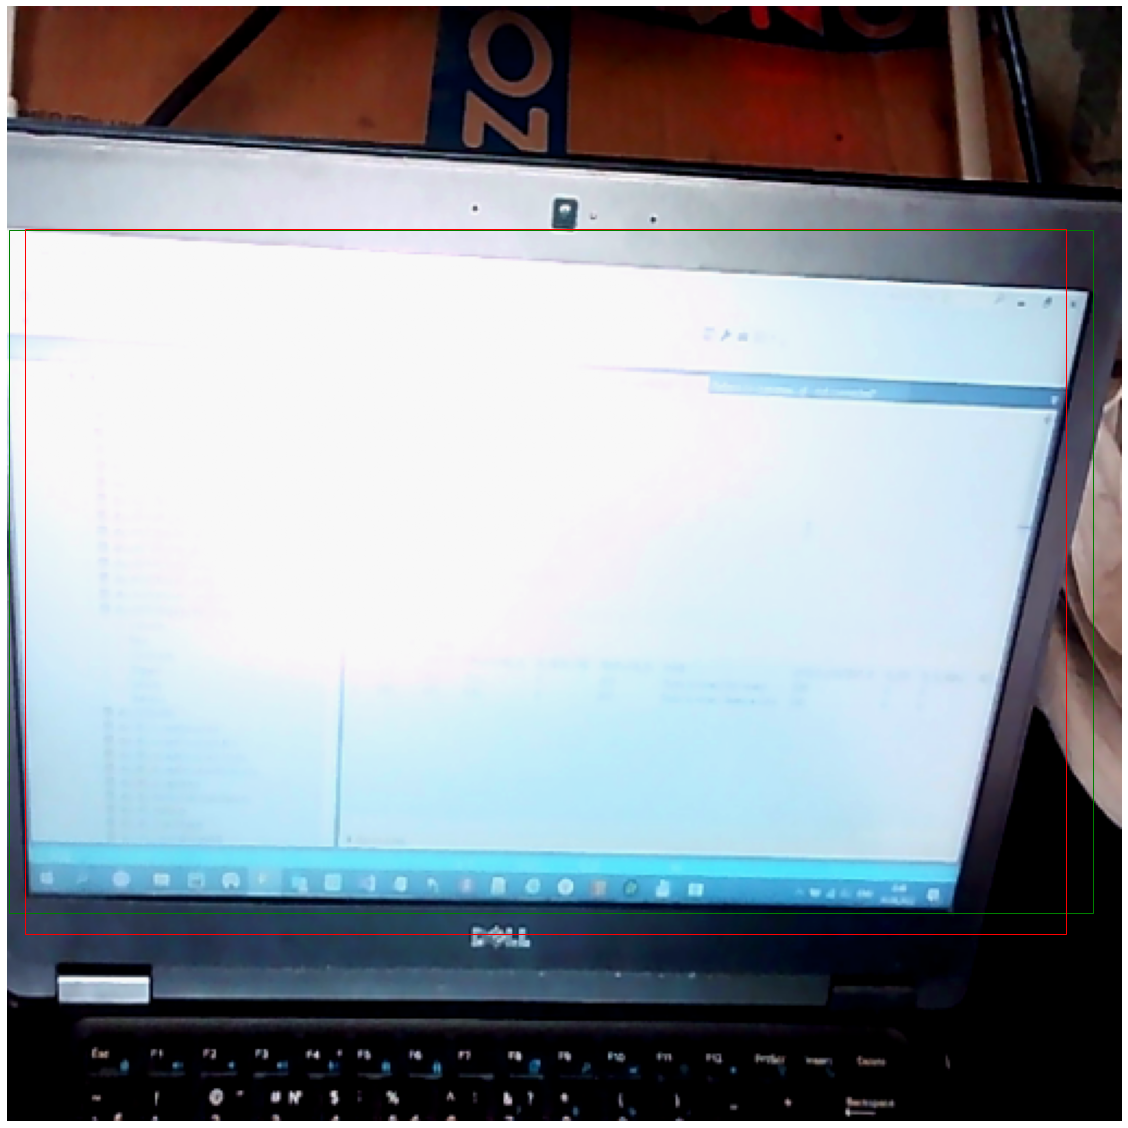

In [72]:
val = random.choice([e for e in range(len(ds_train))])
print(val)
smpl = ds_train[val]
print(smpl[2])
box_pred = model_boxs(torch.tensor([smpl[0].numpy()])).detach().numpy()[0]

fig, ax = plt.subplots()

fig.set_size_inches(24.5, 20.5)
#image = mpimg.imread(smpl[2])
image = np.moveaxis(smpl[0].numpy(), 0, -1)
box1 = smpl[1]

ax.add_patch(
         patches.Rectangle(
           (box1[0] * image.shape[1], 
            box1[1] * image.shape[0]),
            box1[2] * image.shape[1],
            box1[3] * image.shape[0],
            edgecolor = 'green',
            fill=False
         ))

ax.add_patch(
         patches.Rectangle(
           (box_pred[0] * image.shape[1], 
            box_pred[1] * image.shape[0]),
            box_pred[2] * image.shape[1],
            box_pred[3] * image.shape[0],
            edgecolor = 'red',
            fill=False
         ))

ax.imshow(np.moveaxis(smpl[0].numpy(), 0, 2))
plt.axis("off")
plt.show()

In [73]:
import random

class OlivettiFacesDataset_(Dataset):
    def __init__(self, df, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = trf.ToPILImage()
        self.unique_label = np.unique(train_df['label'])
        
        if self.is_train:            
            self.images = df.iloc[:, 1].values#.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)
        self.change_positives()
        
    def __len__(self):
        return len(self.images)
    
    def change_positives(self):
        self.unique_class = {} 
        for label in np.unique(train_df['label']):
            df_tmp = train_df.loc[train_df['label'] == label]
            self.unique_class[str(label)] = df_tmp.iloc[random.randint(0, len(df_tmp))]['link_data']
    
    def load_img(self, path):
        return np.load(f'{params["path_img"]}data_{path}.npy').astype(np.uint8).reshape(params['size'], params['size'], 1)

    def __getitem__(self, item):        
        anchor_img = self.load_img(self.images[item])
        if self.is_train:
            anchor_label = self.labels[item]
            positive_img = self.load_img(self.unique_class[str(anchor_label)])
            negative_img = [self.load_img(self.unique_class[str(idx)]) for idx in self.unique_label if idx != anchor_label]
            
            #-----------
            #negative_img = self.unique_class[str(random.choise([idx for idx in self.unique_label if idx != anchor_label]))]
            #-----------            
            #positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]
            #positive_item = positive_list[0]
            #positive_img = np.load(f'{params["path_img"]}data_{self.images[positive_item]}.npy').astype(np.uint8).reshape(params['size'], params['size'], 1)
            
            #negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            #negative_item = negative_list[0]
            #negative_img = np.load(f'{params["path_img"]}data_{self.images[negative_item]}.npy').astype(np.uint8).reshape(params['size'], params['size'], 1)
            #-----------
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = [self.transform(self.to_pil(img)) for img in negative_img]
                
            return anchor_img, positive_img, negative_img, torch.tensor(np.array([anchor_label]))
        
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img

In [74]:
test_torch_transform = trf.Compose([
    trf.Resize((params['size_recognition'], params['size_recognition'])),
    trf.ToTensor(),
])

In [75]:
train_ds = OlivettiFacesDataset_(train_df, 
                 train=True,
                 transform=test_torch_transform)
train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True, num_workers=4)

In [76]:
np.shape(train_ds[0][0])

torch.Size([1, 128, 128])

174


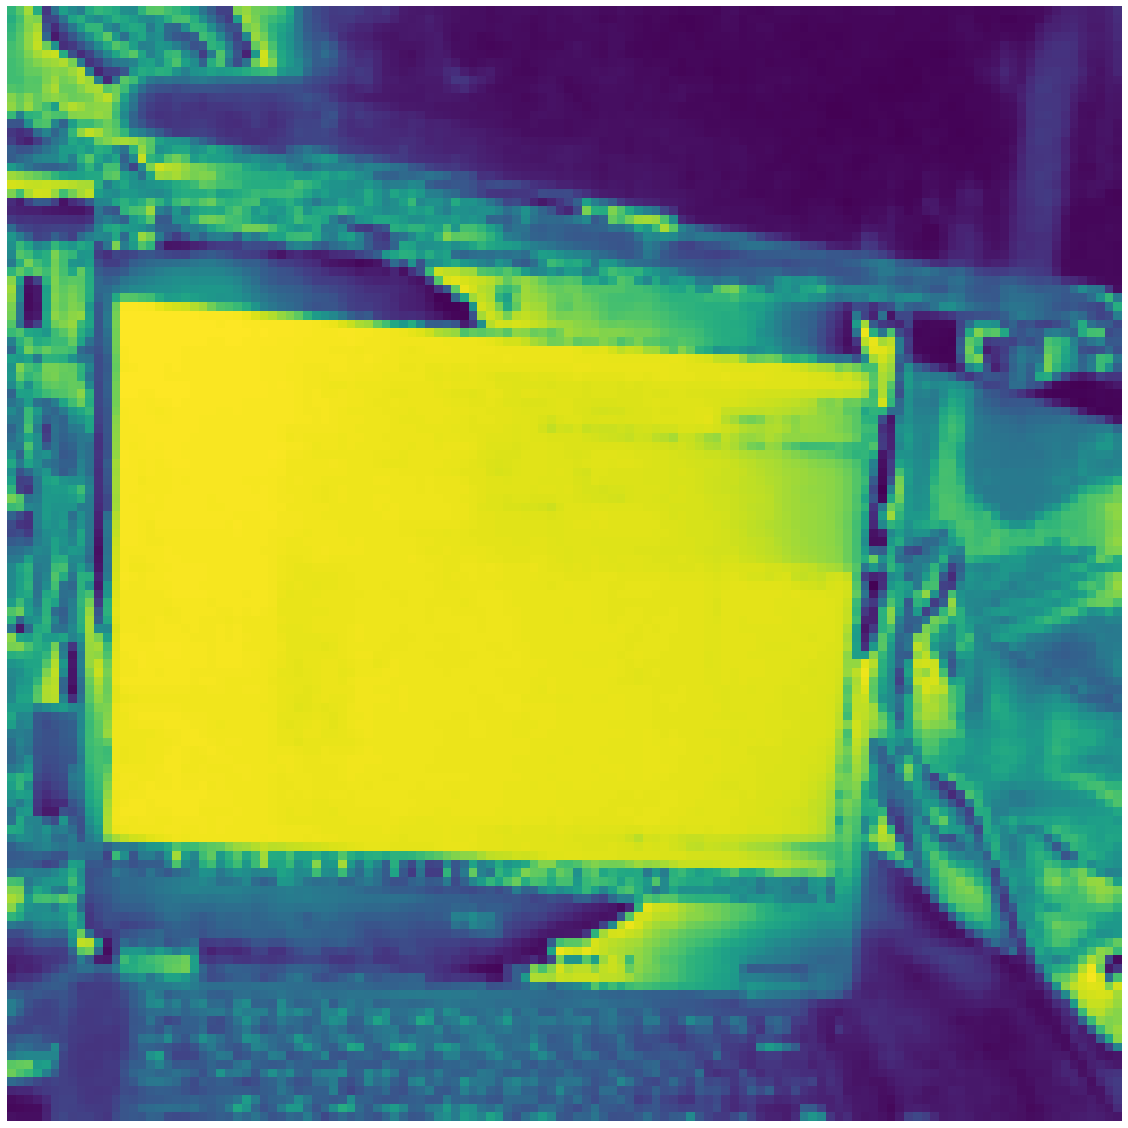

In [77]:
val = random.choice([e for e in range(len(ds_train))])
print(val)
smpl = train_ds[val]

fig, ax = plt.subplots()

fig.set_size_inches(24.5, 20.5)
#image = mpimg.imread(smpl[2])
image = np.moveaxis(smpl[0].numpy(), 0, -1)
ax.imshow(image)
plt.axis("off")
plt.show()

In [78]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv_1 = nn.Sequential(
            #nn.Conv2d(1, 1, 1,padding=1),
            #nn.PReLU(),
            nn.Conv2d(1, 32, 5),
            #nn.PReLU(),
        )
        self.conv_2 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            #nn.PReLU(),
        )
        self.conv_3 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 5),
            #nn.PReLU(),
        )
        self.conv_4 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128*4*4, 512),
            nn.Linear(512, 256),
            nn.PReLU(),
            nn.Linear(256, emb_dim)
        )
        
    def forward(self, x):
        #print(np.shape(x))
        x = F.elu(self.conv_1(x))
        x = F.elu(self.conv_2(x))
        x = F.elu(self.conv_3(x))
        x = self.conv_4(x)
        #print(x.shape)
        x = x.view(-1, 128*4*4)
        #x = x.view(-1, 2048)
        x = self.fc(x)
        #print(np.shape(x))
        #x = nn.functional.normalize(x)
        return x

In [79]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [80]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).abs().pow(2).sum(0).pow(0.5)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:

        
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
               
        
        distance = (distance_positive - distance_negative + self.margin)
        zeros = (distance > 0).float()
        distance = distance * zeros
        losses = distance            
        

        return losses.mean()

In [81]:
train_ds[0][0]

tensor([[[0.9333, 0.9490, 0.9608,  ..., 0.3647, 0.3647, 0.6745],
         [0.9843, 0.9882, 0.9922,  ..., 0.3725, 0.3216, 0.4314],
         [0.9922, 0.9922, 0.9922,  ..., 0.4039, 0.3059, 0.2863],
         ...,
         [0.8078, 0.8275, 0.8745,  ..., 0.1373, 0.0941, 0.1176],
         [0.7922, 0.8078, 0.8314,  ..., 0.1216, 0.1059, 0.0941],
         [0.8824, 0.8196, 0.8039,  ..., 0.2314, 0.1059, 0.1412]]])

In [82]:
val = torch.tensor(np.array([[1,2,3],[4,5,6]]))

print(np.shape(val))

val = val[None, :, :]
print(np.shape(val))

torch.Size([2, 3])
torch.Size([1, 2, 3])


In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print(torch.cuda.get_device_name())

NVIDIA GeForce GTX 1050 Ti


In [84]:
device = torch.device(params["device"])

model = Network(params['embedding_dims'])
model.apply(init_weights)
model = torch.jit.script(model).to(device)

In [85]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [86]:
criterion = torch.jit.script(TripletLoss())
criterion = nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance(p=2.0))
criterion = nn.TripletMarginWithDistanceLoss(distance_function=nn.CosineSimilarity())

In [97]:
model.load_state_dict(torch.load('./models/recogn_id_vga_dict_2.mdl'))

<All keys matched successfully>

In [98]:
loss_min = 0.065933324

In [99]:
with open("./models/recogn_id_vga_dict_2_centers.json", "r") as f:
    val = f.read()
    if val != '' and val != None:
        train_loader.dataset.unique_class = json.loads(val)

In [80]:
train_loader.dataset.change_positives()

In [ ]:
model.train()
ep = 48 #params['epochs']
for epoch in tqdm_step(range(ep), desc="Epochs"):
    running_loss = []
    #if epoch % 10 == 0:
    #    train_loader.dataset.change_positives()
    loss_arr = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm_step(train_loader, desc="Training", leave=False)):
        anchor_img =   anchor_img  .to(device)
        positive_img = positive_img.to(device)
        #negative_img = negative_img.to(device)

        for sample in negative_img:
            negative_img = sample.to(device)
            
            optimizer.zero_grad()
            
            anchor_out = model(anchor_img)
            
            positive_out = model(positive_img)
            
            negative_out = model(negative_img)

            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()
            loss_arr.append(loss.cpu().detach().numpy())
        
        running_loss.append(np.mean(loss_arr))
    print(np.mean(running_loss))
    print(loss_min )
    if np.mean(running_loss) < loss_min:
        loss_min = running_loss[-1]
        torch.save(model.state_dict(), './models/recogn_id_vga_dict_2.mdl')
        print('Сохранено!')
        
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, ep, np.mean(running_loss)))

Epochs:   0%|          | 0/48 [00:00<?, ?it/s]

Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.84837836
1.0
Сохранено!
Epoch: 1/48 - Loss: 0.8750


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.7871872
0.84837836
Сохранено!
Epoch: 2/48 - Loss: 0.7954


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.7650059
0.7871872
Сохранено!
Epoch: 3/48 - Loss: 0.7586


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.7358855
0.7650059
Сохранено!
Epoch: 4/48 - Loss: 0.7505


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.6925999
0.7358855
Сохранено!
Epoch: 5/48 - Loss: 0.7202


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.6228156
0.6925999
Сохранено!
Epoch: 6/48 - Loss: 0.6115


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.5505078
0.6228156
Сохранено!
Epoch: 7/48 - Loss: 0.5545


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.4722092
0.5505078
Сохранено!
Epoch: 8/48 - Loss: 0.4985


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.410514
0.4722092
Сохранено!
Epoch: 9/48 - Loss: 0.4307


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.3580558
0.410514
Сохранено!
Epoch: 10/48 - Loss: 0.3682


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.31496474
0.3580558
Сохранено!
Epoch: 11/48 - Loss: 0.3345


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.28579342
0.31496474
Сохранено!
Epoch: 12/48 - Loss: 0.2857


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.26654223
0.28579342
Сохранено!
Epoch: 13/48 - Loss: 0.2726


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.24687368
0.26654223
Сохранено!
Epoch: 14/48 - Loss: 0.2512


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.236805
0.24687368
Сохранено!
Epoch: 15/48 - Loss: 0.2475


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.22293471
0.236805
Сохранено!
Epoch: 16/48 - Loss: 0.2251


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.21173704
0.22293471
Сохранено!
Epoch: 17/48 - Loss: 0.2098


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.19809692
0.21173704
Сохранено!
Epoch: 18/48 - Loss: 0.1908


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.19190077
0.19809692
Сохранено!
Epoch: 19/48 - Loss: 0.1891


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.18295717
0.19190077
Сохранено!
Epoch: 20/48 - Loss: 0.1699


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.173128
0.18295717
Сохранено!
Epoch: 21/48 - Loss: 0.1825


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.1657243
0.173128
Сохранено!
Epoch: 22/48 - Loss: 0.1563


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.16019431
0.1657243
Сохранено!
Epoch: 23/48 - Loss: 0.1566


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

In [127]:
model.train()
ep = 6 #params['epochs']
for epoch in tqdm_step(range(ep), desc="Epochs"):
    running_loss = []
    #if epoch % 10 == 0:
    #    train_loader.dataset.change_positives()
    loss_arr = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm_step(train_loader, desc="Training", leave=False)):
        anchor_img =   anchor_img  .to(device)
        positive_img = positive_img.to(device)
        #negative_img = negative_img.to(device)

        for sample in negative_img:
            negative_img = sample.to(device)
            
            optimizer.zero_grad()
            
            anchor_out = model(anchor_img)
            
            positive_out = model(positive_img)
            
            negative_out = model(negative_img)

            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()
            loss_arr.append(loss.cpu().detach().numpy())
        
        running_loss.append(np.mean(loss_arr))
    print(np.mean(running_loss))
    print(loss_min)
    if np.mean(running_loss) < loss_min:
        loss_min = np.mean(running_loss)
        torch.save(model.state_dict(), './models/recogn_id_vga_dict_2.mdl')
        print('Сохранено!')
        
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, ep, np.mean(running_loss)))

Epochs:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.06601914
0.065933324
Epoch: 1/6 - Loss: 0.0660


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.07131084
0.065933324
Epoch: 2/6 - Loss: 0.0713


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.07350516
0.065933324
Epoch: 3/6 - Loss: 0.0735


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.06897453
0.065933324
Epoch: 4/6 - Loss: 0.0690


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.07796027
0.065933324
Epoch: 5/6 - Loss: 0.0780


Training:   0%|          | 0/1212 [00:00<?, ?it/s]

0.07961773
0.065933324
Epoch: 6/6 - Loss: 0.0796


In [118]:
with open("./models/recogn_id_vga_dict_2_centers.json", "w") as f:
    f.write(json.dumps({k:int(v) for k, v in train_loader.dataset.unique_class.items()}))

In [577]:
torch.save(model.state_dict(), './models/recogn_id_vga_dict_2.mdl')

In [100]:
data_params_lst = []
data_targets_lst = []
for idx in range(len(train_ds)):
    #print(np.shape(train_ds[idx][0].numpy()))
    mdl = torch.flatten(model(torch.tensor(np.array([train_ds[idx][0].numpy()])))).detach().numpy()
    #print(np.shape(mdl))
    data_params_lst.append(mdl)
    data_targets_lst.append(torch.tensor([float(train_ds[idx][3])]).numpy()[0])
data_params_lst = np.array(data_params_lst)
data_targets_lst = np.array(data_targets_lst)

In [101]:
target = [data_convert['name_num'][e] for e in targets]

In [102]:
X_train, X_test, y_train, y_test=train_test_split(data_params_lst, data_targets_lst, test_size=0.3, stratify=target, random_state=0)

In [103]:
n_components=30

In [104]:
pca=PCA(n_components=n_components, whiten=True)
pca.fit(X_train)

PCA(n_components=30, whiten=True)

In [105]:
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

In [106]:
np.shape(pca.mean_)

(1152,)

Text(0.5, 1.0, 'Average Face')

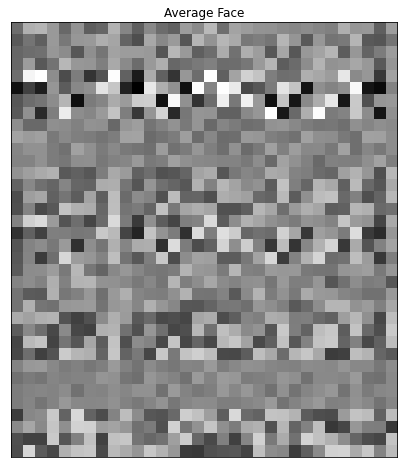

In [107]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.imshow(pca.mean_.reshape((36,32)), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Face')

In [108]:
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

In [109]:
clf = SVC()
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print("accuracy score:{:.2f}".format(metrics.accuracy_score(y_test, y_pred)))

accuracy score:0.97


In [114]:
import pickle as pk

In [115]:
pk.dump(pca, open("./models/pca.pkl","wb"))

In [116]:
pk.dump(clf, open("./models/clf.pkl","wb"))

In [110]:
X_train_, X_test_, y_train_, y_test_=train_test_split(data_params_lst, data_targets_lst, test_size=0.3, stratify=target, random_state=0)

In [111]:
from sklearn.decomposition import PCA
pca_=PCA(n_components=2)
pca_.fit(data_params_lst)
X_pca_= pca_.transform(data_params_lst)

In [112]:
import pickle as pk

In [113]:
pk.dump(pca, open("./models/pca.pkl","wb"))

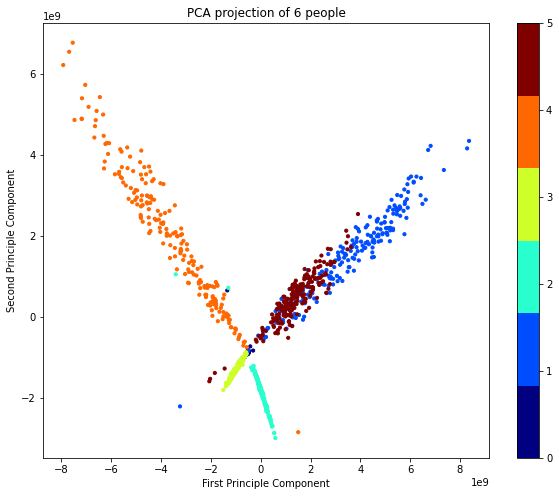

In [114]:
number_of_people=len(data_convert['num_name'])
index_range=len(data_targets_lst)
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)
scatter=ax.scatter(X_pca_[:index_range,0],
            X_pca_[:index_range,1], 
            c=data_targets_lst[:index_range],
            s=10,
           cmap=plt.get_cmap('jet', number_of_people)
          )

ax.set_xlabel("First Principle Component")
ax.set_ylabel("Second Principle Component")
ax.set_title("PCA projection of {} people".format(number_of_people))

fig.colorbar(scatter)

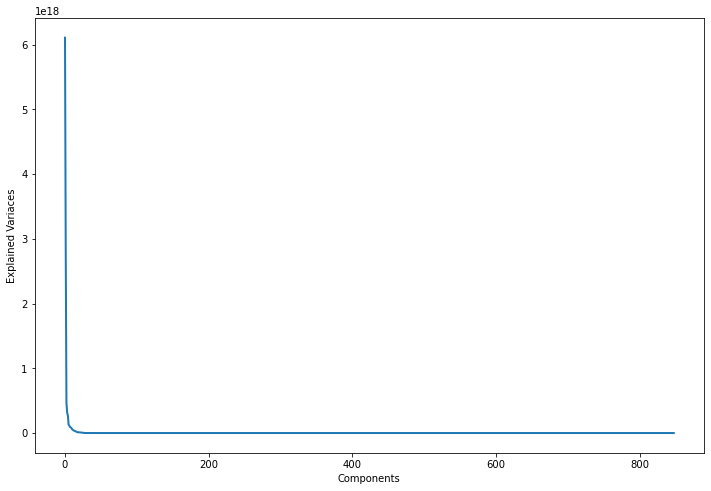

In [115]:
pca=PCA()
pca.fit(X_train_)

plt.figure(1, figsize=(12,8))

plt.plot(pca.explained_variance_, linewidth=2)
 
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

In [116]:
from sklearn.decomposition import PCA
pca_=PCA(n_components=30)
pca_.fit(data_params_lst)
X_pca_= pca_.transform(data_params_lst)

In [117]:
X_train_pca_=pca_.transform(X_train_)
X_test_pca_=pca_.transform(X_test_)

In [158]:
pk.dump(pca_, open("./models/pca_.pkl","wb"))

In [118]:
clf = SVC()
clf.fit(X_train_pca_, y_train_)
y_pred = clf.predict(X_test_pca_)
print("accuracy score:{:.2f}".format(metrics.accuracy_score(y_test_.astype('int32'), y_pred)))

accuracy score:0.97


In [119]:
pk.dump(clf, open("./models/clf_.pkl","wb"))

In [120]:
from catboost import CatBoostRegressor, CatBoostClassifier
grid_cat = CatBoostClassifier()
grid_cat

In [121]:
grid_cat = CatBoostClassifier(depth=10, iterations=100, learning_rate=0.1)
grid_cat.fit(X_train_, y_train_)

0:	learn: 1.4482527	total: 6s	remaining: 9m 53s
1:	learn: 1.2276892	total: 11.6s	remaining: 9m 30s
2:	learn: 1.0655265	total: 17.3s	remaining: 9m 17s
3:	learn: 0.9324084	total: 22.9s	remaining: 9m 8s
4:	learn: 0.8261528	total: 28.6s	remaining: 9m 4s
5:	learn: 0.7377277	total: 34.6s	remaining: 9m 1s
6:	learn: 0.6577640	total: 40.2s	remaining: 8m 53s
7:	learn: 0.5954958	total: 45.8s	remaining: 8m 46s
8:	learn: 0.5414326	total: 51.4s	remaining: 8m 39s
9:	learn: 0.4897893	total: 57s	remaining: 8m 33s
10:	learn: 0.4467199	total: 1m 2s	remaining: 8m 26s
11:	learn: 0.4096162	total: 1m 8s	remaining: 8m 20s
12:	learn: 0.3762509	total: 1m 13s	remaining: 8m 14s
13:	learn: 0.3437790	total: 1m 19s	remaining: 8m 9s
14:	learn: 0.3172249	total: 1m 25s	remaining: 8m 2s
15:	learn: 0.2942707	total: 1m 30s	remaining: 7m 57s
16:	learn: 0.2712730	total: 1m 36s	remaining: 7m 51s
17:	learn: 0.2515375	total: 1m 42s	remaining: 7m 45s
18:	learn: 0.2346427	total: 1m 47s	remaining: 7m 39s
19:	learn: 0.2175570	tota

In [123]:
y_pred_rf = grid_cat.predict(X_test_)
print("accuracy score:{:.2f}".format(metrics.accuracy_score(y_test_, y_pred_rf)))

accuracy score:0.99


In [124]:
grid_cat.save_model('./models/cat_predict.mdl')

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [132]:
log_reg = LogisticRegression()
knn = KNeighborsClassifier()
r_forrest = RandomForestClassifier()

In [133]:
r_forest_params = {'n_estimators':range(200),
                    'max_depth':range(14),
                    'min_samples_leaf':range(2,8),
                    'min_samples_split':range(10)
                    }

In [134]:
log_reg_params = {'max_iter':range(50,501,50)}

In [135]:
knn_params = {'algorithm':['ball_tree','kd_tree','brute'],
              'leaf_size': range(2,91,30),
             }

In [136]:
grid_knn = GridSearchCV(knn,knn_params,cv=5)

In [137]:
grid_log_reg = GridSearchCV(log_reg,log_reg_params,cv=5)

In [138]:
grid_forest = RandomForestClassifier()#GridSearchCV(r_forrest,r_forest_params,cv=2)

In [139]:
param_grid = {
    'max_depth':[10],
    'n_estimators': [130],
    'max_features': ['log2'],#['auto', 'sqrt', 'log2']
    'warm_start': [False],
    'verbose': [0,3,5,10]
}

In [140]:
CV_rfc = GridSearchCV(estimator=grid_forest, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_pca_, y_train_)
print(CV_rfc.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
b

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130
building tree 75 of 130
building tree 76 of 130
building tree 77 of 130
building tree 78 of 130
building tree 79 of 130
building tree 80 of 130
building tree 81 of 130
building tree 82 of 130
building tree 83 of 130
building tree 84 of 130
building tree 85 of 130
building tree 86 of 130
building tree 87 of 130
building tree 88 of 130
building tree 89 of 130
building tree 90 of 130
building tree 91 of 130
building tree 92 of 130
building tree 93 of 130
building tree 94 of 130
building tree 95 of 130
building tree 96 of 130
building tree 97 of 130
building tree 98 of 130
building tree 99

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
building tree 43 of 130
building tree 44 of 130
building tree 45 of 130
building tree 46 of 130
building tree 47 of 130
building tree 48 of 130
building tree 49 of 130
building tree 50 of 130
building tree 51 of 130
building tree 52 of 130
building tree 53 of 130
building tree 54 of 130
building tree 55 of 130
building tree 56 of 130
building tree 57 of 130
building tree 58

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
b

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
b

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
b

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
b

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
b

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
b

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
b

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.

building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
building tree 43 of 130
building tree 44 of 130
building tree 45 of 130
building tree 46 of 130
building tree 47 of 130
building tree 48 of 130
building tree 49 of 130
building tree 50 of 130
building tree 51 of 130
building tree 52 of 130
building tree 53 of 130
building tree 54 of 130
building tree 55 of 130
building tree 56 of 130
building tree 57 of 130
building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130
building tree 75 of 130
building tree 76 of 130
building tree 77 of 130
building tree 78 of 130
building tree 79 of 130
building tree 80

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
b

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

building tree 92 of 130
building tree 93 of 130
building tree 94 of 130
building tree 95 of 130
building tree 96 of 130
building tree 97 of 130
building tree 98 of 130
building tree 99 of 130
building tree 100 of 130
building tree 101 of 130
building tree 102 of 130
building tree 103 of 130
building tree 104 of 130
building tree 105 of 130
building tree 106 of 130
building tree 107 of 130
building tree 108 of 130
building tree 109 of 130
building tree 110 of 130
building tree 111 of 130
building tree 112 of 130
building tree 113 of 130
building tree 114 of 130
building tree 115 of 130
building tree 116 of 130
building tree 117 of 130
building tree 118 of 130
building tree 119 of 130
building tree 120 of 130
building tree 121 of 130
building tree 122 of 130
building tree 123 of 130
building tree 124 of 130
building tree 125 of 130
building tree 126 of 130
building tree 127 of 130
building tree 128 of 130
building tree 129 of 130
building tree 130 of 130
Using ThreadingBackend as joblib.

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130
building tree 75 of 130
building tree 76 of 130
building tree 77 of 130
building tree 78 of 130
building tree 79 of 130
building tree 80 of 130
building tree 81 of 130
building tree 82 of 130
building tree 83 of 130
building tree 84 of 130
building tree 85 of 130
building tree 86 of 130
building tree 87 of 130
building tree 88 of 130
building tree 89 of 130
building tree 90 of 130
building tree 91 of 130
building tree 92 of 130
building tree 93 of 130
building tree 94 of 130
building tree 95 of 130
building tree 96 of 130
building tree 97 of 130
building tree 98 of 130
building tree 99 of 130
building tree 100 of 130
building tree 101 of 130
building tree 

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
building tree 43 of 130
building tree 44 of 130
building tree 45 of 130
building tree 46 of 130
building tree 47 of 130
building tree 48 of 130
building tree 49 of 130
building tree 50 of 130
building tree 51 of 130
building tree 52 of 130
building tree 53 of 130
building tree 54 of 130
building tree 55 of 130
building tree 56 of 130
building tree 57 of 130
building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished


{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 130, 'verbose': 0, 'warm_start': False}


In [141]:
grid_forest = RandomForestClassifier(max_depth=10,warm_start=False, max_features='log2', n_estimators= 130)

In [142]:
grid_knn.fit(X_train_pca_, y_train_)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': range(2, 91, 30)})

In [143]:
grid_log_reg.fit(X_train_pca_, y_train_)

/home/viktor/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/viktor/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'max_iter': range(50, 501, 50)})

In [144]:
grid_forest.fit(X_train_pca_, y_train_)

RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=130)

In [148]:
y_pred_rf = grid_forest.predict(X_test_pca_)
print('RandomForestClassifier')
print("accuracy score:{:.2f}".format(metrics.accuracy_score(y_test_, y_pred_rf)))

RandomForestClassifier
accuracy score:0.98


In [149]:
y_pred_lr = grid_log_reg.best_estimator_.predict(X_test_pca_)
print('LogisticRegression')
print("accuracy score:{:.2f}".format(metrics.accuracy_score(y_test_, y_pred_lr)))

LogisticRegression
accuracy score:0.97


In [150]:
y_pred = grid_knn.best_estimator_.predict(X_test_pca_)
print('KNN')
print("accuracy score:{:.2f}".format(metrics.accuracy_score(y_test_, y_pred)))

KNN
accuracy score:0.97


In [151]:
param_grid = {
    'depth': [10, 12],
    'learning_rate': [0.005, 0.01, 0.02],
    'iterations': [100, 150]
}

In [152]:
from catboost import CatBoostRegressor, CatBoostClassifier
grid_cat = CatBoostClassifier()
grid_cat

In [154]:
#CV_cat = GridSearchCV(estimator=grid_cat, param_grid=param_grid, cv= 5)
#CV_cat.fit(X_train_pca, y_train)
#print(CV_cat.best_params_)

In [155]:
grid_cat = CatBoostClassifier(depth=10, iterations=100, learning_rate=0.005)
grid_cat.fit(X_train_pca, y_train)

0:	learn: 1.7849585	total: 175ms	remaining: 17.3s
1:	learn: 1.7782708	total: 352ms	remaining: 17.3s
2:	learn: 1.7684072	total: 528ms	remaining: 17.1s
3:	learn: 1.7599870	total: 699ms	remaining: 16.8s
4:	learn: 1.7524379	total: 875ms	remaining: 16.6s
5:	learn: 1.7450693	total: 1.04s	remaining: 16.4s
6:	learn: 1.7356560	total: 1.22s	remaining: 16.2s
7:	learn: 1.7261753	total: 1.4s	remaining: 16s
8:	learn: 1.7144998	total: 1.59s	remaining: 16.1s
9:	learn: 1.7033869	total: 1.81s	remaining: 16.3s
10:	learn: 1.6954066	total: 1.99s	remaining: 16.1s
11:	learn: 1.6864341	total: 2.18s	remaining: 16s
12:	learn: 1.6802416	total: 2.37s	remaining: 15.9s
13:	learn: 1.6713590	total: 2.55s	remaining: 15.7s
14:	learn: 1.6631572	total: 2.74s	remaining: 15.5s
15:	learn: 1.6545170	total: 2.92s	remaining: 15.4s
16:	learn: 1.6448216	total: 3.09s	remaining: 15.1s
17:	learn: 1.6370622	total: 3.27s	remaining: 14.9s
18:	learn: 1.6277699	total: 3.44s	remaining: 14.7s
19:	learn: 1.6198436	total: 3.62s	remaining: 1

In [156]:
y_pred_rf = grid_cat.predict(X_test_pca)
print("accuracy score:{:.2f}".format(metrics.accuracy_score(y_test, y_pred_rf)))

accuracy score:0.97
